In [4]:
import pandas as pd 
import numpy as np
import re
from helpers import *
import matplotlib.pyplot as plt

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Twokenize -- a tokenizer designed for Twitter text in English and some other European languages.
This tokenizer code has gone through a long history:
(1) Brendan O'Connor wrote original version in Python, http://github.com/brendano/tweetmotif
       TweetMotif: Exploratory Search and Topic Summarization for Twitter.
       Brendan O'Connor, Michel Krieger, and David Ahn.
       ICWSM-2010 (demo track), http://brenocon.com/oconnor_krieger_ahn.icwsm2010.tweetmotif.pdf
(2a) Kevin Gimpel and Daniel Mills modified it for POS tagging for the CMU ARK Twitter POS Tagger
(2b) Jason Baldridge and David Snyder ported it to Scala
(3) Brendan bugfixed the Scala port and merged with POS-specific changes
    for the CMU ARK Twitter POS Tagger
(4) Tobi Owoputi ported it back to Java and added many improvements (2012-06)
Current home is http://github.com/brendano/ark-tweet-nlp and http://www.ark.cs.cmu.edu/TweetNLP
There have been at least 2 other Java ports, but they are not in the lineage for the code here.
Ported to Python by Myle Ott <myleott@gmail.com>.
"""
from __future__ import unicode_literals

import operator
import re
import sys

try:
    from html.parser import HTMLParser
except ImportError:
    from HTMLParser import HTMLParser

try:
    import html
except ImportError:
    pass

def regex_or(*items):
    return '(?:' + '|'.join(items) + ')'

Contractions = re.compile(u"(?i)(\w+)(n['’′]t|['’′]ve|['’′]ll|['’′]d|['’′]re|['’′]s|['’′]m)$", re.UNICODE)
Whitespace = re.compile(u"[\s\u0020\u00a0\u1680\u180e\u202f\u205f\u3000\u2000-\u200a]+", re.UNICODE)

punctChars = r"['\"“”‘’.?!…,:;]"
#punctSeq   = punctChars+"+"	#'anthem'. => ' anthem '.
punctSeq   = r"['\"“”‘’]+|[.?!,…]+|[:;]+"	#'anthem'. => ' anthem ' .
entity     = r"&(?:amp|lt|gt|quot);"
#  URLs


# BTO 2012-06: everyone thinks the daringfireball regex should be better, but they're wrong.
# If you actually empirically test it the results are bad.
# Please see https://github.com/brendano/ark-tweet-nlp/pull/9

urlStart1  = r"(?:https?://|\bwww\.)"
commonTLDs = r"(?:com|org|edu|gov|net|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|pro|tel|travel|xxx)"
ccTLDs	 = r"(?:ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|" + \
r"bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|" + \
r"er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|" + \
r"hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|" + \
r"lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|" + \
r"nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|sk|" + \
r"sl|sm|sn|so|sr|ss|st|su|sv|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|" + \
r"va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|za|zm|zw)"	#TODO: remove obscure country domains?
urlStart2  = r"\b(?:[A-Za-z\d-])+(?:\.[A-Za-z0-9]+){0,3}\." + regex_or(commonTLDs, ccTLDs) + r"(?:\."+ccTLDs+r")?(?=\W|$)"
urlBody    = r"(?:[^\.\s<>][^\s<>]*?)?"
urlExtraCrapBeforeEnd = regex_or(punctChars, entity) + "+?"
urlEnd     = r"(?:\.\.+|[<>]|\s|$)"
url        = regex_or(urlStart1, urlStart2) + urlBody + "(?=(?:"+urlExtraCrapBeforeEnd+")?"+urlEnd+")"


# Numeric
timeLike   = r"\d+(?::\d+){1,2}"
#numNum     = r"\d+\.\d+"
numberWithCommas = r"(?:(?<!\d)\d{1,3},)+?\d{3}" + r"(?=(?:[^,\d]|$))"
numComb	 = u"[\u0024\u058f\u060b\u09f2\u09f3\u09fb\u0af1\u0bf9\u0e3f\u17db\ua838\ufdfc\ufe69\uff04\uffe0\uffe1\uffe5\uffe6\u00a2-\u00a5\u20a0-\u20b9]?\\d+(?:\\.\\d+)+%?"

# Abbreviations
boundaryNotDot = regex_or("$", r"\s", r"[“\"?!,:;]", entity)
aa1  = r"(?:[A-Za-z]\.){2,}(?=" + boundaryNotDot + ")"
aa2  = r"[^A-Za-z](?:[A-Za-z]\.){1,}[A-Za-z](?=" + boundaryNotDot + ")"
standardAbbreviations = r"\b(?:[Mm]r|[Mm]rs|[Mm]s|[Dd]r|[Ss]r|[Jj]r|[Rr]ep|[Ss]en|[Ss]t)\."
arbitraryAbbrev = regex_or(aa1, aa2, standardAbbreviations)
separators  = "(?:--+|―|—|~|–|=)"
decorations = u"(?:[♫♪]+|[★☆]+|[♥❤♡]+|[\u2639-\u263b]+|[\ue001-\uebbb]+)"
thingsThatSplitWords = r"[^\s\.,?\"]"
embeddedApostrophe = thingsThatSplitWords+r"+['’′]" + thingsThatSplitWords + "*"

#  Emoticons
# myleott: in Python the (?iu) flags affect the whole expression
#normalEyes = "(?iu)[:=]" # 8 and x are eyes but cause problems
normalEyes = "[:=]" # 8 and x are eyes but cause problems
wink = "[;]"
noseArea = "(?:|-|[^a-zA-Z0-9 ])" # doesn't get :'-(
happyMouths = r"[D\)\]\}]+"
sadMouths = r"[\(\[\{]+"
tongue = "[pPd3]+"
otherMouths = r"(?:[oO]+|[/\\]+|[vV]+|[Ss]+|[|]+)" # remove forward slash if http://'s aren't cleaned

# mouth repetition examples:
# @aliciakeys Put it in a love song :-))
# @hellocalyclops =))=))=)) Oh well

# myleott: try to be as case insensitive as possible, but still not perfect, e.g., o.O fails
#bfLeft = u"(♥|0|o|°|v|\\$|t|x|;|\u0ca0|@|ʘ|•|・|◕|\\^|¬|\\*)".encode('utf-8')
bfLeft = u"(♥|0|[oO]|°|[vV]|\\$|[tT]|[xX]|;|\u0ca0|@|ʘ|•|・|◕|\\^|¬|\\*)"
bfCenter = r"(?:[\.]|[_-]+)"
bfRight = r"\2"
s3 = r"(?:--['\"])"
s4 = r"(?:<|&lt;|>|&gt;)[\._-]+(?:<|&lt;|>|&gt;)"
s5 = "(?:[.][_]+[.])"
# myleott: in Python the (?i) flag affects the whole expression
#basicface = "(?:(?i)" +bfLeft+bfCenter+bfRight+ ")|" +s3+ "|" +s4+ "|" + s5
basicface = "(?:" +bfLeft+bfCenter+bfRight+ ")|" +s3+ "|" +s4+ "|" + s5

eeLeft = r"[＼\\ƪԄ\(（<>;ヽ\-=~\*]+"
eeRight= u"[\\-=\\);'\u0022<>ʃ）/／ノﾉ丿╯σっµ~\\*]+"
eeSymbol = r"[^A-Za-z0-9\s\(\)\*:=-]"
eastEmote = eeLeft + "(?:"+basicface+"|" +eeSymbol+")+" + eeRight

oOEmote = r"(?:[oO]" + bfCenter + r"[oO])"


emoticon = regex_or(
        # Standard version  :) :( :] :D :P
        "(?:>|&gt;)?" + regex_or(normalEyes, wink) + regex_or(noseArea,"[Oo]") + regex_or(tongue+r"(?=\W|$|RT|rt|Rt)", otherMouths+r"(?=\W|$|RT|rt|Rt)", sadMouths, happyMouths),

        # reversed version (: D:  use positive lookbehind to remove "(word):"
        # because eyes on the right side is more ambiguous with the standard usage of : ;
        regex_or("(?<=(?: ))", "(?<=(?:^))") + regex_or(sadMouths,happyMouths,otherMouths) + noseArea + regex_or(normalEyes, wink) + "(?:<|&lt;)?",

        #inspired by http://en.wikipedia.org/wiki/User:Scapler/emoticons#East_Asian_style
        eastEmote.replace("2", "1", 1), basicface,
        # iOS 'emoji' characters (some smileys, some symbols) [\ue001-\uebbb]
        # TODO should try a big precompiled lexicon from Wikipedia, Dan Ramage told me (BTO) he does this

        # myleott: o.O and O.o are two of the biggest sources of differences
        #          between this and the Java version. One little hack won't hurt...
        oOEmote
)

Hearts = "(?:<+/?3+)+" #the other hearts are in decorations

Arrows = regex_or(r"(?:<*[-―—=]*>+|<+[-―—=]*>*)", u"[\u2190-\u21ff]+")

# BTO 2011-06: restored Hashtag, AtMention protection (dropped in original scala port) because it fixes
# "hello (#hashtag)" ==> "hello (#hashtag )"  WRONG
# "hello (#hashtag)" ==> "hello ( #hashtag )"  RIGHT
# "hello (@person)" ==> "hello (@person )"  WRONG
# "hello (@person)" ==> "hello ( @person )"  RIGHT
# ... Some sort of weird interaction with edgepunct I guess, because edgepunct
# has poor content-symbol detection.

# This also gets #1 #40 which probably aren't hashtags .. but good as tokens.
# If you want good hashtag identification, use a different regex.
Hashtag = "#[a-zA-Z0-9_]+"  #optional: lookbehind for \b
#optional: lookbehind for \b, max length 15
AtMention = "[@＠][a-zA-Z0-9_]+"

# I was worried this would conflict with at-mentions
# but seems ok in sample of 5800: 7 changes all email fixes
# http://www.regular-expressions.info/email.html
Bound = r"(?:\W|^|$)"
Email = regex_or("(?<=(?:\W))", "(?<=(?:^))") + r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,4}(?=" +Bound+")"

# We will be tokenizing using these regexps as delimiters
# Additionally, these things are "protected", meaning they shouldn't be further split themselves.
Protected  = re.compile(
    regex_or(
        Hearts,
        url,
        Email,
        timeLike,
        #numNum,
        numberWithCommas,
        numComb,
        emoticon,
        Arrows,
        entity,
        punctSeq,
        arbitraryAbbrev,
        separators,
        decorations,
        embeddedApostrophe,
        Hashtag,
        AtMention), re.UNICODE)

# Edge punctuation
# Want: 'foo' => ' foo '
# While also:   don't => don't
# the first is considered "edge punctuation".
# the second is word-internal punctuation -- don't want to mess with it.
# BTO (2011-06): the edgepunct system seems to be the #1 source of problems these days.
# I remember it causing lots of trouble in the past as well.  Would be good to revisit or eliminate.

# Note the 'smart quotes' (http://en.wikipedia.org/wiki/Smart_quotes)
#edgePunctChars    = r"'\"“”‘’«»{}\(\)\[\]\*&" #add \\p{So}? (symbols)
edgePunctChars    = u"'\"“”‘’«»{}\\(\\)\\[\\]\\*&" #add \\p{So}? (symbols)
edgePunct    = "[" + edgePunctChars + "]"
notEdgePunct = "[a-zA-Z0-9]" # content characters
offEdge = r"(^|$|:|;|\s|\.|,)"  # colon here gets "(hello):" ==> "( hello ):"
EdgePunctLeft  = re.compile(offEdge + "("+edgePunct+"+)("+notEdgePunct+")", re.UNICODE)
EdgePunctRight = re.compile("("+notEdgePunct+")("+edgePunct+"+)" + offEdge, re.UNICODE)

def splitEdgePunct(input):
    input = EdgePunctLeft.sub(r"\1\2 \3", input)
    input = EdgePunctRight.sub(r"\1 \2\3", input)
    return input

# The main work of tokenizing a tweet.
def simpleTokenize(text):

    # Do the no-brainers first
    splitPunctText = splitEdgePunct(text)

    textLength = len(splitPunctText)

    # BTO: the logic here got quite convoluted via the Scala porting detour
    # It would be good to switch back to a nice simple procedural style like in the Python version
    # ... Scala is such a pain.  Never again.

    # Find the matches for subsequences that should be protected,
    # e.g. URLs, 1.0, U.N.K.L.E., 12:53
    bads = []
    badSpans = []
    for match in Protected.finditer(splitPunctText):
        # The spans of the "bads" should not be split.
        if (match.start() != match.end()): #unnecessary?
            bads.append( [splitPunctText[match.start():match.end()]] )
            badSpans.append( (match.start(), match.end()) )

    # Create a list of indices to create the "goods", which can be
    # split. We are taking "bad" spans like
    #     List((2,5), (8,10))
    # to create
    #     List(0, 2, 5, 8, 10, 12)
    # where, e.g., "12" here would be the textLength
    # has an even length and no indices are the same
    indices = [0]
    for (first, second) in badSpans:
        indices.append(first)
        indices.append(second)
    indices.append(textLength)

    # Group the indices and map them to their respective portion of the string
    splitGoods = []
    for i in range(0, len(indices), 2):
        goodstr = splitPunctText[indices[i]:indices[i+1]]
        splitstr = goodstr.strip().split(" ")
        splitGoods.append(splitstr)

    #  Reinterpolate the 'good' and 'bad' Lists, ensuring that
    #  additonal tokens from last good item get included
    zippedStr = []
    for i in range(len(bads)):
        zippedStr = addAllnonempty(zippedStr, splitGoods[i])
        zippedStr = addAllnonempty(zippedStr, bads[i])
    zippedStr = addAllnonempty(zippedStr, splitGoods[len(bads)])

    # BTO: our POS tagger wants "ur" and "you're" to both be one token.
    # Uncomment to get "you 're"
    #splitStr = []
    #for tok in zippedStr:
    #    splitStr.extend(splitToken(tok))
    #zippedStr = splitStr

    return zippedStr

def addAllnonempty(master, smaller):
    for s in smaller:
        strim = s.strip()
        if (len(strim) > 0):
            master.append(strim)
    return master

# "foo   bar " => "foo bar"
def squeezeWhitespace(input):
    return Whitespace.sub(" ", input).strip()

# Final pass tokenization based on special patterns
def splitToken(token):
    m = Contractions.search(token)
    if m:
        return [m.group(1), m.group(2)]
    return [token]

# Assume 'text' has no HTML escaping.
def tokenize(text):
    return simpleTokenize(squeezeWhitespace(text))


# Twitter text comes HTML-escaped, so unescape it.
# We also first unescape &amp;'s, in case the text has been buggily double-escaped.
def normalizeTextForTagger(text):
    assert sys.version_info[0] >= 3 and sys.version_info[1] > 3, 'Python version >3.3 required'
    text = text.replace("&amp;", "&")
    text = html.unescape(text)
    return text

# This is intended for raw tweet text -- we do some HTML entity unescaping before running the tagger.
#
# This function normalizes the input text BEFORE calling the tokenizer.
# So the tokens you get back may not exactly correspond to
# substrings of the original text.
def tokenizeRawTweetText(text):
    tokens = tokenize(normalizeTextForTagger(text))
    return tokens


##### Loading tweets, filter for english, merge hashtags

In [30]:
#loading shiet
data = pd.read_csv(access_folder() + 'rus_troll_tweet_text.csv')
data = data[data.tweet_language == 'en']
hashtag_info = pd.read_csv(access_folder() + 'rus_troll_tweet_stats.csv', usecols=['tweetid', 'hashtags', 'tweet_time'])

In [7]:
print('data shape: {}, hashtags shape: {}'.format(data.shape, hashtag_info.shape))

data shape: (3261931, 3), hashtags shape: (9041308, 2)


In [8]:
data = pd.merge(data, hashtag_info, on='tweetid')[['tweet_text', 'hashtags']]

In [9]:
data.replace('[]',np.nan, inplace=True)
data.dropna(how='any', inplace=True)

In [10]:
data.shape

(1562218, 2)

In [32]:
data.head()

,tweetid,tweet_language,tweet_text
8,567357519547207680,en,"As sun and cloud give way to moon and shadow, ..."
10,493894187079974912,en,"Down in the comfort of strangers, I..."
11,493688319902220288,en,Im laughing more than i should #USA
12,497543470211678209,en,"No, I'm not saying I'm sorry"
33,500956712657223680,en,Laugh it all off in your face


half of the tweets have hashtags

###### cleaning the data

In [11]:
data_clean = data
#data_clean = data.replace('#\w+', '', regex=True).replace('@\w+', '', regex=True).replace('RT ', '', regex=True)
data_clean.tweet_text = data_clean.tweet_text.apply(lambda x: re.sub(r'http\S+', '', x))
data_clean.head()

,tweet_text,hashtags
2,Im laughing more than i should #USA,[USA]
13,"RT @Danimal941: No shirt, no shoes, no sanctua...",[RejectedStatueOfLibertySigns]
15,RT @Real923LA: A few of our lucky listeners ha...,"[BigSean, IDecidedTour]"
16,RT @ReignOfApril: The Immortal Life of #Henrie...,[HenriettaLacks]
17,"RT @RappersIQ: #Papoose Ft. #RemyMa ""Black Lov...","[Papoose, RemyMa, Remix, PRO, TBT, Day, Follow..."


##### tests on tokenizer and stopwords

In [12]:
tokens = tokenizeRawTweetText(': ciao at my ahahah phew business busy')
tokens

[':', 'ciao', 'at', 'my', 'ahahah', 'phew', 'business', 'busy']

In [13]:
#stopwords = open(access_folder() + 'twitter-stopwords.txt' , "r").read().split(',')
stopwords2 = open(access_folder() + 'morestopwords.txt' , "r").read().split('\n')
stopwords2 = list(filter(None, stopwords2)) # fastest
stopwords2 = [word for word in stopwords2 if word[0]!='#' ]
stopwords3 = open(access_folder() + 'common-english-prep-conj.txt' , "r").read().split(',')
stopwords4 = open(access_folder() + 'common-english-words.txt' , "r").read().split(',')

stopwords = []
stopwords = stopwords + stopwords2 + stopwords3 + stopwords4

In [14]:
len(stopwords)

26471

In [15]:
tokens = [token for token in tokens if token not in stopwords]
tokens

[':', 'ciao', 'business', 'busy']

##### duplicating ashtags

In [16]:
data_clean.shape

(1562218, 2)

In [17]:
duplicated = pd.DataFrame(data_clean.hashtags.str.split(', ').tolist(), index=data_clean.tweet_text).stack()
duplicated = duplicated.reset_index()[[0, 'tweet_text']] # var1 variable is currently labeled 0
duplicated.columns = ['hashtags', 'tweet_text'] # renaming var1
duplicated.hashtags = duplicated.hashtags.apply(lambda tag: tag.replace('[', ''))
duplicated.hashtags = duplicated.hashtags.apply(lambda tag: tag.replace(']', ''))

In [18]:
duplicated.shape

(2150872, 2)

In [19]:
duplicated.head()

,hashtags,tweet_text
0,USA,Im laughing more than i should #USA
1,RejectedStatueOfLibertySigns,"RT @Danimal941: No shirt, no shoes, no sanctua..."
2,BigSean,RT @Real923LA: A few of our lucky listeners ha...
3,IDecidedTour,RT @Real923LA: A few of our lucky listeners ha...
4,HenriettaLacks,RT @ReignOfApril: The Immortal Life of #Henrie...


##### Picking important hashtags

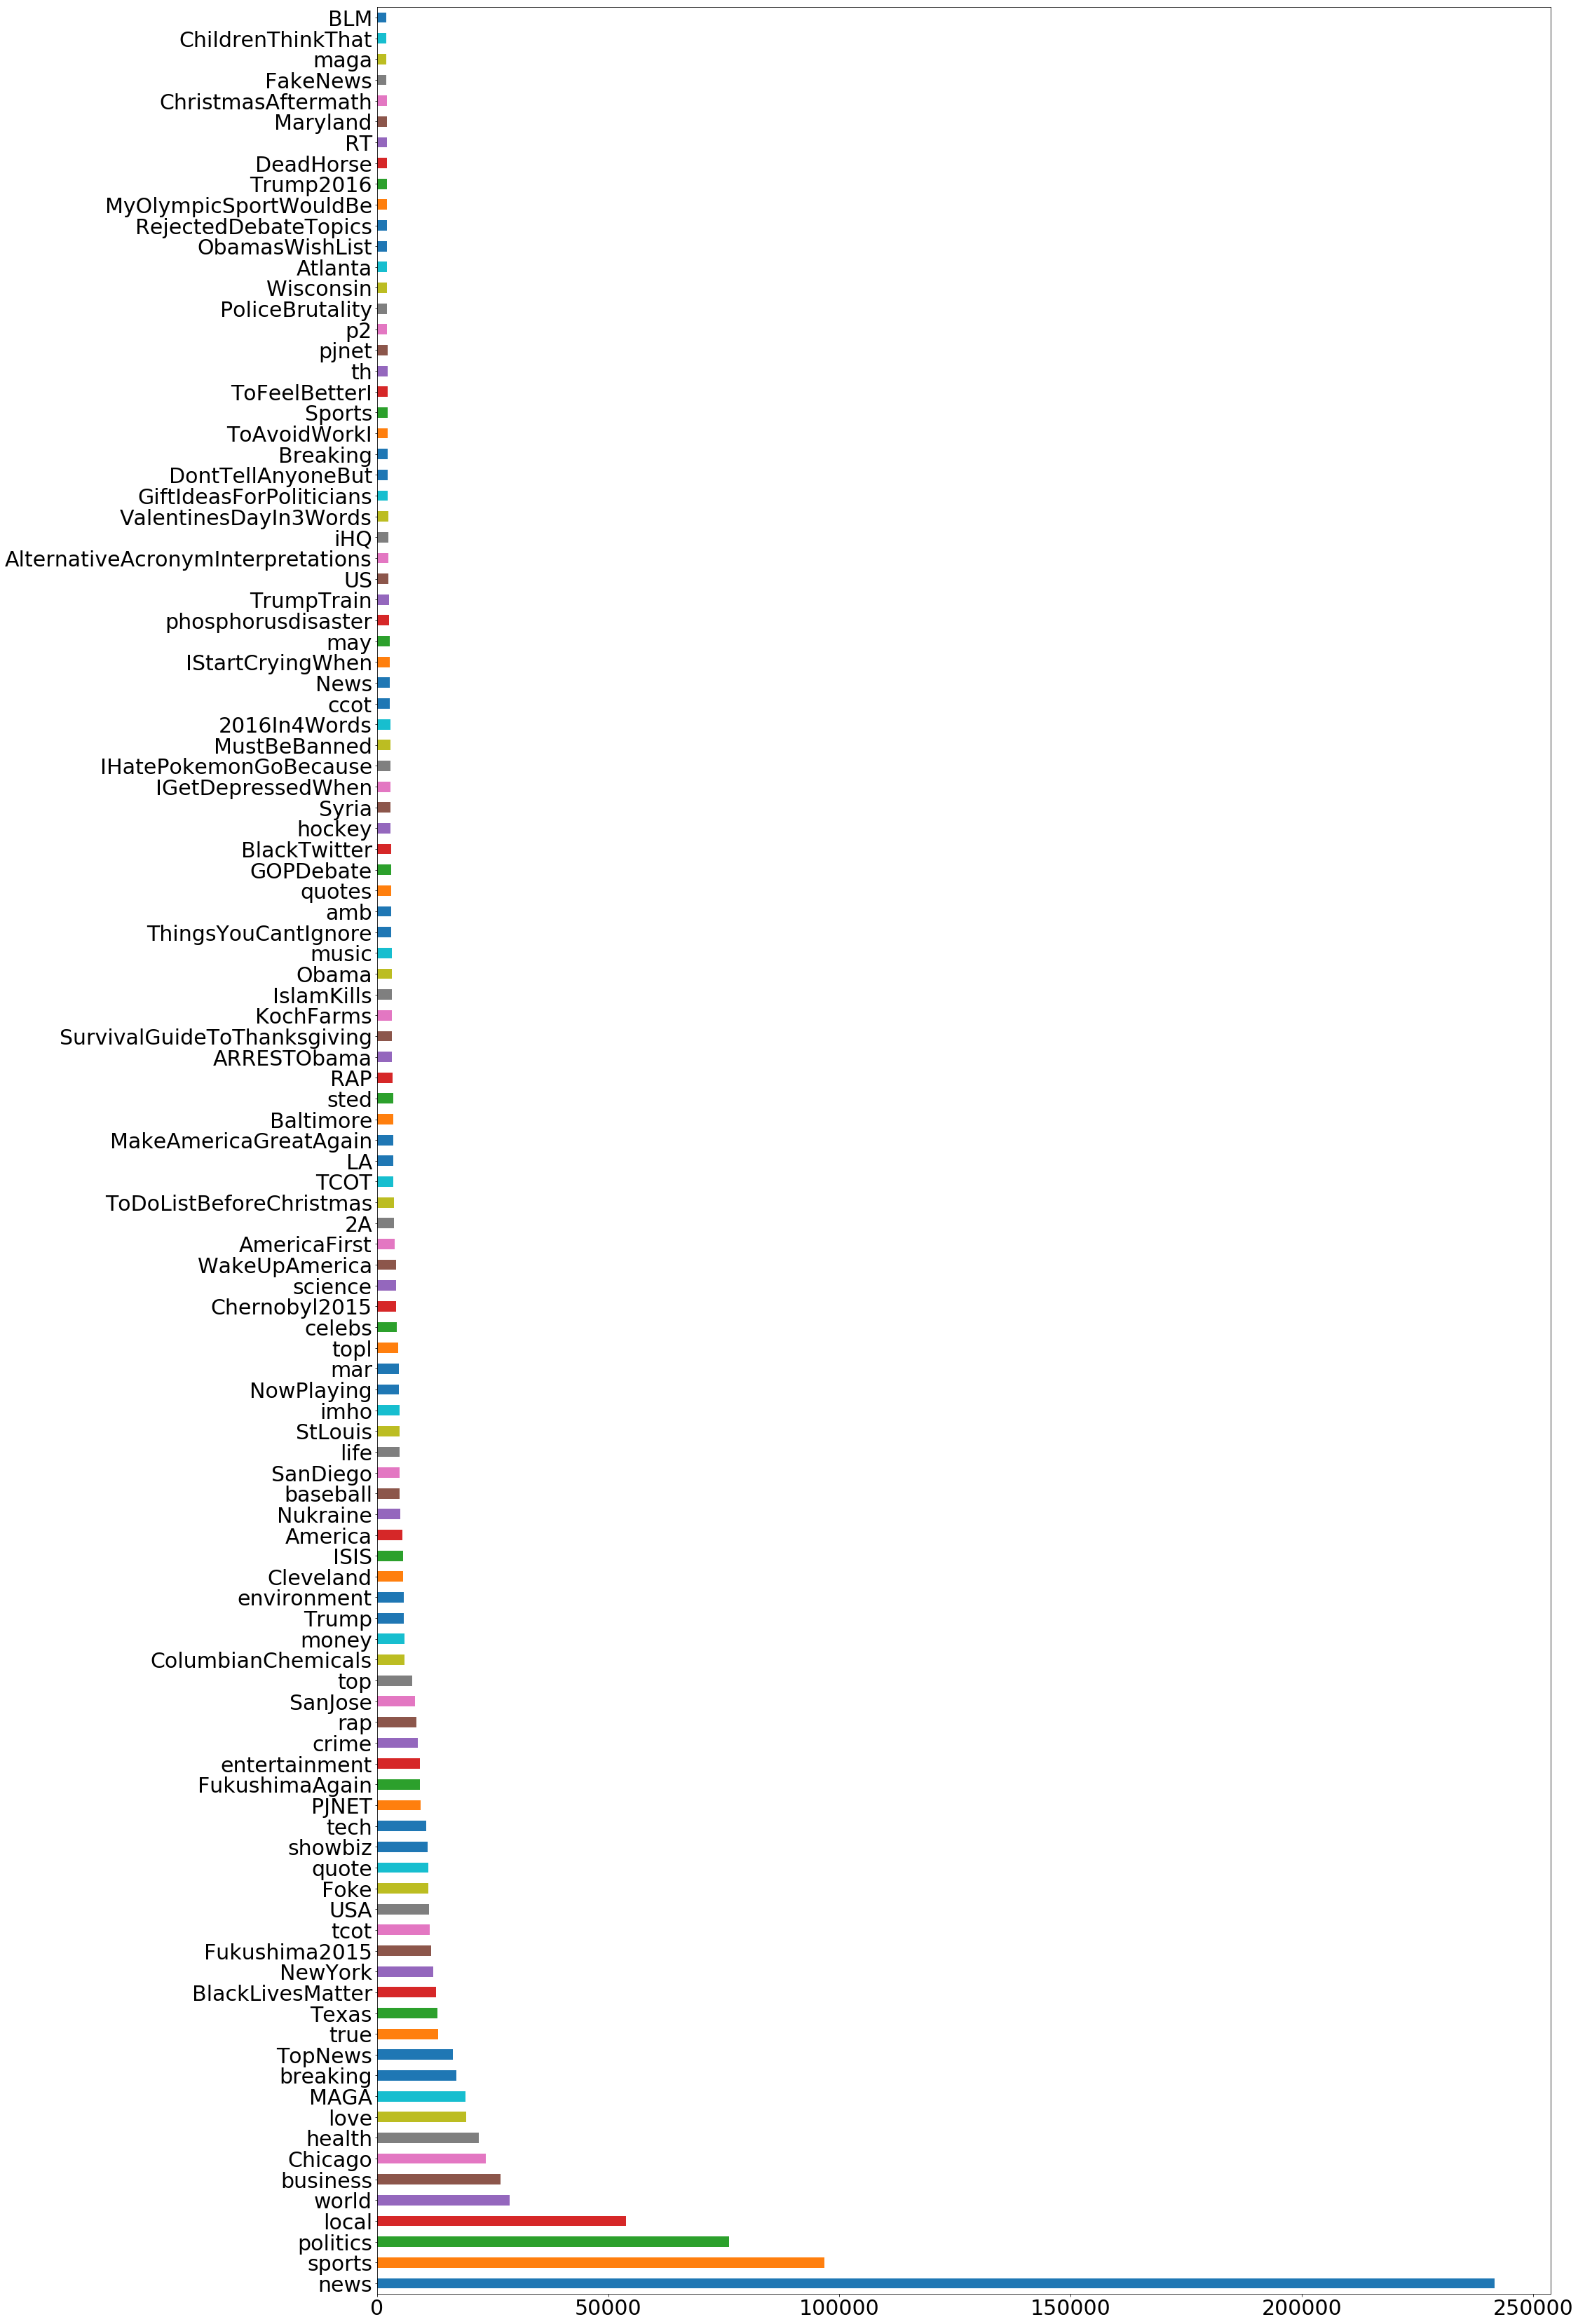

In [24]:
hash_frequencies = duplicated.hashtags.value_counts()

plt.figure(figsize=(30,60))
plt.rcParams.update({'font.size': 30})
hash_frequencies[hash_frequencies > 2000].plot.barh()

In [21]:
print('rateo tweets considered in top hashtags: {}'.format(hash_frequencies[hash_frequencies > 2000].sum()/hash_frequencies.sum()))

rateo tweets considered in top hashtags: 0.5080892772791686


In [29]:
for mar in duplicated[duplicated.hashtags == 'USFA'].tweet_text.values:
    print(mar)


When you are dealing with an unconcerned government it is survival of the fittest. Enlist in the #USFA at… 
Dear Mr. Jefferson. They have already done that in spades. Enlist in the #USFA at  Stand u… 
Why don't they both join the other socialists and stop pretending. The #USFA patriots await your enlistment at… 
It is a little more than a bear. These bears are gun owners. Stand up &amp; join the #USFA at  
RT @AbnInfVet: Without the U.S. military we would be a conquered nation in chains. Enlist in the #USFA at  Patriots…
We wonder where the federal courts were when all this happened. Enlist in the #USFA at  Re… 
RT GulfWarVet123: When is the U.S. Military going to get more pay than these clowns? Join us in the #USFA at … 
Any careful reading of the Constitution will tell you that Roe v Wade is void. Enlist in the #USFA at… 
The RINO Exit Ramp has a new number. Let's use it. Enlist in the #USFA at  Patriot central… 
Eric may have struck a nerve with that statement. Wake up D.C. Enlist i

RT AbnInfVet: If these young people knew what socialism really is they would be petrified. Enlist in the #USFA at… 
RT @AbnInfVet: Disney has truly become the Mickey Mouse outfit. The #USFA awaits your enlistment at  Patriot centra…


In [59]:
duplicated.hashtags[(duplicated.hashtags == 'USFA') | (duplicated.hashtags == 'trump')]

332         USFA
2195        USFA
2202        USFA
3506        USFA
4552       trump
4656        USFA
7857        USFA
8372       trump
9499        USFA
9501        USFA
9844        USFA
9845        USFA
9846        USFA
10022       USFA
11019       USFA
12283       USFA
12559       USFA
12560       USFA
12765       USFA
12766       USFA
17229       USFA
17721       USFA
18973      trump
20578       USFA
20758      trump
21230      trump
22410      trump
24776      trump
25089      trump
26298      trump
           ...  
2128942    trump
2131259     USFA
2131260     USFA
2131261     USFA
2131536    trump
2131776     USFA
2131779     USFA
2132233    trump
2133864    trump
2134502     USFA
2134503     USFA
2134504     USFA
2135174     USFA
2135863    trump
2136921    trump
2139902     USFA
2140858    trump
2141174     USFA
2142348    trump
2143069    trump
2143713     USFA
2143907    trump
2144251    trump
2145904    trump
2146148     USFA
2146600     USFA
2147224     USFA
2147302     US

##### tokenizing

In [52]:
def token_stop(tweet, filter_size = 2):

    tokens = tokenizeRawTweetText(tweet)
    tokens = [token.lower() for token in tokens if len(token) >= filter_size]
    tokens = [token for token in tokens if token not in stopwords]
    
    return tokens

In [ ]:
duplicated.tweet_text.iloc[20:50]

In [53]:
duplicated.tweet_text.iloc[20:50].apply(token_stop)

20                     [determine, exactly, #offensive]
21    [know, fat, girls, believe, #bodyacceptance, u...
22                            [#morningjoe, know, mean]
23    [rt, @2a43e23eca4448ffca04ed734fc93ed2039e1d73...
24     [attitude, feminism, one, pic, #feminismisawful]
25    [rt, @fansofsheistt, new, @sheistt, banners, ....
26    [rt, @fansofsheistt, new, @sheistt, banners, ....
27    [rt, @fansofsheistt, new, @sheistt, banners, ....
28    [rt, @fansofsheistt, new, @sheistt, banners, ....
29    [rt, @rnrmaryland, real, active, shooter, live...
30    [rt, @rnrmaryland, real, active, shooter, live...
31    [rt, @rnrmaryland, real, active, shooter, live...
32    [horse, pulling, carriage, #cleveland, appears...
33    [john, carroll, university, gets, $2.25, milli...
34    [#local, spring, cook, book, healthy, chocolat...
35    [new, poll, shows, trump, lead, intact, critic...
36    [rocky, river, prepares, more, flooding, city,...
37    [rocky, river, prepares, more, flooding, c

In [ ]:
tokenized = duplicated.tweet_text.apply(token_stop)